In [1]:
import pandas as pd

In [2]:
df = pd.read_csv(
    "../data/consumption.csv", usecols=["prediction_unit_id", "datetime", "target"]
)[["prediction_unit_id", "datetime", "target"]].rename(
    columns={"prediction_unit_id": "unique_id", "datetime": "ds", "target": "y"}
)
df["ds"] = pd.to_datetime(df["ds"])
df.head()

,unique_id,ds,y
0,0,2021-09-01,96.590
1,1,2021-09-01,17.314
2,2,2021-09-01,656.859
3,3,2021-09-01,59.000
4,4,2021-09-01,501.760


In [3]:
df["y"] = df["y"].ffill()
df.isna().sum()

unique_id    0
ds           0
y            0
dtype: int64

# Train/Test split

In [4]:
# taking the last 48 hours for test
horizon = 48
for i in df["unique_id"].unique():
    if i == df["unique_id"].unique()[0]:
        df_test = df[df["unique_id"]==i][-horizon:]
        continue
    df_test = pd.concat([df_test, df[df["unique_id"]==i][-horizon:]])
    
df_test.sort_index(inplace=True)
print(df_test.shape)
df_test.head()

(3312, 3)


,unique_id,ds,y
906150,26,2023-03-28 00:00:00,5.137
906217,26,2023-03-28 01:00:00,4.212
906284,26,2023-03-28 02:00:00,4.917
906351,26,2023-03-28 03:00:00,4.195
906418,26,2023-03-28 04:00:00,4.518


In [5]:
train_idx = [idx for idx in df.index if idx not in df_test.index]
df_train = df.loc[train_idx]
df_train.shape
df_train.head()

,unique_id,ds,y
0,0,2021-09-01,96.590
1,1,2021-09-01,17.314
2,2,2021-09-01,656.859
3,3,2021-09-01,59.000
4,4,2021-09-01,501.760


In [6]:
df.shape[0] == df_train.shape[0] + df_test.shape[0]

True

In [7]:
df.shape[1] == df_train.shape[1] == df_test.shape[1]

True

# Training

In [8]:
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences

In [9]:
# col_params = dict(id_col="building_id", time_col="datetime", target_col="consumption")
# col_params

In [10]:
import lightgbm as lgb

lgb_params = {
    'verbosity': -1,
    'num_leaves': 512,
}

fcst = MLForecast(
    models={
        'avg': lgb.LGBMRegressor(**lgb_params),
        # 'q75': lgb.LGBMRegressor(**lgb_params, objective='quantile', alpha=0.75),
        # 'q25': lgb.LGBMRegressor(**lgb_params, objective='quantile', alpha=0.25),
    },
    freq="h",
    target_transforms=[Differences([24])],
    lags=[i+1 for i in range(24)],
    lag_transforms={
        1: [ExpandingMean()],
        24: [RollingMean(window_size=48)],
    },
    date_features=["month", "dayofweek", "hour"],
)

# fcst.preprocess(df_train, **col_params).head()
fcst.preprocess(df_train).head()

,unique_id,ds,y,lag1,lag2,lag3,lag4,lag5,lag6,lag7,...,lag20,lag21,lag22,lag23,lag24,expanding_mean_lag1,rolling_mean_lag24_window_size48,month,dayofweek,hour
5795,0,2021-09-04 23:00:00,-6.630,10.176,-16.948,30.391,7.926,-17.201,-3.185,6.491,...,25.584,8.909,32.118,14.813,19.389,4.519704,5.480750,9,5,23
5796,1,2021-09-04 23:00:00,-0.656,4.648,5.220,-13.346,-10.982,-2.404,-1.357,1.997,...,4.737,4.358,2.976,7.491,7.787,0.645268,0.864937,9,5,23
5797,2,2021-09-04 23:00:00,-35.639,-62.993,5.519,17.114,47.251,-16.126,-23.379,32.545,...,165.606,172.671,151.648,160.884,149.861,33.502592,38.503042,9,5,23
5798,3,2021-09-04 23:00:00,-1.100,-4.200,-3.600,-4.900,-17.900,-16.500,-38.600,-10.800,...,18.500,17.600,17.100,11.700,-1.600,-7.554930,4.497917,9,5,23
5799,4,2021-09-04 23:00:00,-68.429,-83.631,-70.391,-16.480,-11.291,-59.362,-127.090,-178.232,...,76.277,87.274,57.055,13.774,29.268,-38.533958,21.538812,9,5,23


In [11]:
import time

start = time.time()
# fcst.fit(df_train, **col_params)
fcst.fit(df_train)
end = time.time()
t = end - start
t

8.365523338317871

# Evaluate

In [12]:
from functools import partial
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mape, mase, mae, rmse

In [13]:
df_eval = pd.merge(df_test, fcst.predict(horizon), on=["unique_id", "ds"])
daily_mase = partial(mase, seasonality=24)

In [14]:
error_ref = evaluate(
    df_eval, metrics=[mape, daily_mase, mae, rmse], train_df=df_train#, **col_params
)
error_ref.drop(columns=["unique_id"]).groupby("metric").mean()

,avg
metric,
mae,44.860327
mape,0.660978
mase,0.650544
rmse,64.338779


# Error distribution

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

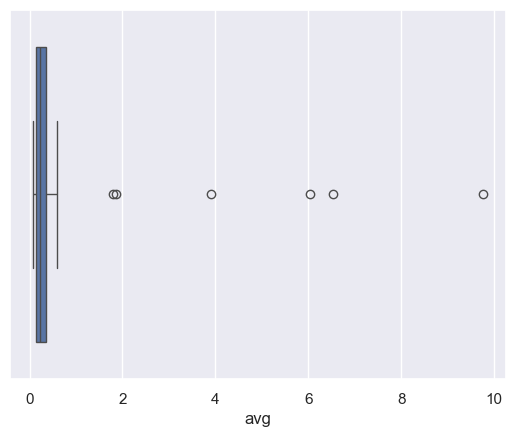

In [18]:
mask = error_ref["metric"] == "mape"
sns.boxplot(x=error_ref.loc[mask, "avg"])
plt.show()

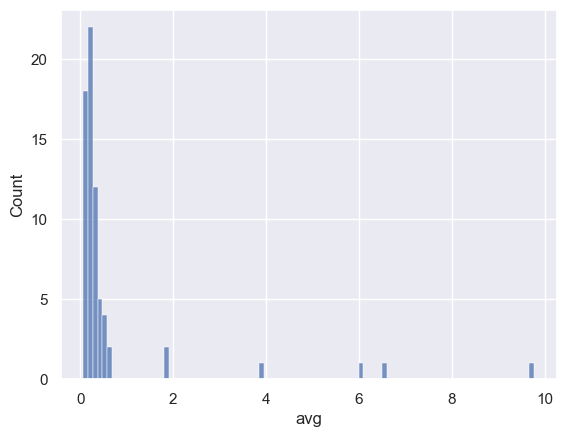

In [19]:
sns.histplot(x=error_ref.loc[mask, "avg"])
plt.show()

# HPO

## Random Search

## Optuna

### Default optimization

In [20]:
import optuna

from mlforecast.auto import (
    AutoLightGBM,
    AutoMLForecast,
    AutoModel,
    AutoRidge,
    ridge_space,
)

c:\Users\gabriel.chehade\Documents\Projets\Github\Predict-Energy-Behavior-of-Prosumers-with-Machine-and-Deep-Learning\ML-training\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
optuna.logging.set_verbosity(optuna.logging.ERROR)
auto_mlf = AutoMLForecast(
    models={'lgb': AutoLightGBM(), 'ridge': AutoRidge()},
    freq="h",
    season_length=24,
)

In [22]:
%%time
auto_mlf.fit(
    df_train,
    n_windows=2,
    h=horizon,
    num_samples=2,  # number of trials to run
    # **col_params
)

CPU times: total: 3min 24s
Wall time: 1min 2s


AutoMLForecast(models={'lgb': AutoModel(model=LGBMRegressor), 'ridge': AutoModel(model=Ridge)})

In [23]:
preds = auto_mlf.predict(horizon)
preds

,unique_id,ds,lgb,ridge
0,0,2023-05-30 00:00:00,565.454859,473.285688
1,0,2023-05-30 01:00:00,563.887968,435.791833
2,0,2023-05-30 02:00:00,548.292567,420.404486
3,0,2023-05-30 03:00:00,538.535335,425.605559
4,0,2023-05-30 04:00:00,519.713864,404.789790
...,...,...,...,...
3307,68,2023-05-31 19:00:00,7.687514,1.378594
3308,68,2023-05-31 20:00:00,5.374252,2.770000
3309,68,2023-05-31 21:00:00,6.561874,7.424761
3310,68,2023-05-31 22:00:00,9.323739,10.326647


### Evaluation

In [24]:
df_eval = pd.merge(df_test, preds, on=["unique_id", "ds"])
daily_mase = partial(mase, seasonality=24)

In [25]:
error = evaluate(
    df_eval, metrics=[mape, daily_mase, mae, rmse], train_df=df_train
)
error.drop(columns=["unique_id"]).groupby("metric").mean()

,lgb,ridge
metric,,
mae,110.089964,49.134963
mape,1.349701,0.513245
mase,1.212543,0.752745
rmse,143.436201,66.745755


In [41]:
(error.drop(columns=["unique_id"]).groupby("metric").mean().values
 - error_ref.drop(columns=["unique_id"]).groupby("metric").mean().values)

array([[65.22963673,  4.27463601],
       [ 0.68872293, -0.14773295],
       [ 0.56199856,  0.10220105],
       [79.09742193,  2.4069758 ]])

### Tuning lgbm parameters

In [42]:
def my_lgb_config(trial: optuna.Trial):
    return {
        'learning_rate': 0.05,
        'verbosity': -1,
        'num_leaves': trial.suggest_int('num_leaves', 2, 128, log=True),
        'objective': trial.suggest_categorical('objective', ['l1', 'l2', 'mape']),
    }

my_lgb = AutoModel(
    model=lgb.LGBMRegressor(),
    config=my_lgb_config,
)


In [43]:
auto_mlf = AutoMLForecast(
    models={'my_lgb': my_lgb},
    freq="h",
    season_length=24,
).fit(
    df_train,
    n_windows=2,
    h=horizon,
    num_samples=2,
)

In [44]:
preds = auto_mlf.predict(horizon)
preds

,unique_id,ds,my_lgb
0,0,2023-05-30 00:00:00,484.121214
1,0,2023-05-30 01:00:00,449.387858
2,0,2023-05-30 02:00:00,440.608171
3,0,2023-05-30 03:00:00,434.272479
4,0,2023-05-30 04:00:00,416.491666
...,...,...,...
3307,68,2023-05-31 19:00:00,3.281953
3308,68,2023-05-31 20:00:00,4.022080
3309,68,2023-05-31 21:00:00,4.815580
3310,68,2023-05-31 22:00:00,5.054192


### Evaluation

In [45]:
df_eval = pd.merge(df_test, preds, on=["unique_id", "ds"])
daily_mase = partial(mase, seasonality=24)

In [46]:
error = evaluate(
    df_eval, metrics=[mape, daily_mase, mae, rmse], train_df=df_train
)
error.drop(columns=["unique_id"]).groupby("metric").mean()

,my_lgb
metric,
mae,65.756558
mape,0.875407
mase,1.051813
rmse,83.118148


In [47]:
(error.drop(columns=["unique_id"]).groupby("metric").mean().values
 - error_ref.drop(columns=["unique_id"]).groupby("metric").mean().values)

array([[20.89623081],
       [ 0.21442847],
       [ 0.4012686 ],
       [18.77936859]])

### Tuning ridge parameters

In [52]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge

ridge_pipeline = make_pipeline(
    ColumnTransformer(
        [('encoder', OneHotEncoder(), ['unique_id'])],
        remainder='passthrough',
    ),
    Ridge()
)
my_auto_ridge = AutoModel(
    ridge_pipeline,
    # the space must have the name of the estimator followed by the parameter
    # you could also tune the encoder here
    lambda trial: {f'ridge__{k}': v for k, v in ridge_space(trial).items()},
)

In [55]:
auto_mlf = AutoMLForecast(
    models={'ridge': my_auto_ridge},
    freq="h",
    season_length=24,
    fit_config=lambda trial: {'static_features': ['unique_id']}
).fit(
    df_train,
    n_windows=2,
    h=horizon,
    num_samples=2,
)

In [56]:
preds = auto_mlf.predict(horizon)
preds

,unique_id,ds,ridge
0,0,2023-05-30 00:00:00,464.089417
1,0,2023-05-30 01:00:00,419.716974
2,0,2023-05-30 02:00:00,401.566783
3,0,2023-05-30 03:00:00,409.073716
4,0,2023-05-30 04:00:00,385.492595
...,...,...,...
3307,68,2023-05-31 19:00:00,2.227154
3308,68,2023-05-31 20:00:00,3.431440
3309,68,2023-05-31 21:00:00,8.573857
3310,68,2023-05-31 22:00:00,12.121622


### Evaluation

In [57]:
df_eval = pd.merge(df_test, preds, on=["unique_id", "ds"])
daily_mase = partial(mase, seasonality=24)

In [58]:
error = evaluate(
    df_eval, metrics=[mape, daily_mase, mae, rmse], train_df=df_train
)
error.drop(columns=["unique_id"]).groupby("metric").mean()

,ridge
metric,
mae,45.261171
mape,0.891970
mase,0.738090
rmse,60.205129


In [59]:
(error.drop(columns=["unique_id"]).groupby("metric").mean().values
 - error_ref.drop(columns=["unique_id"]).groupby("metric").mean().values)

array([[ 0.4008446 ],
       [ 0.23099201],
       [ 0.08754579],
       [-4.13364974]])

### Tuning features

In [62]:
from mlforecast.lag_transforms import ExponentiallyWeightedMean, RollingMean

def my_init_config(trial: optuna.Trial):
    lag_transforms = [
        ExponentiallyWeightedMean(alpha=0.3),
        RollingMean(window_size=24 * 7, min_samples=1),
    ]
    lag_to_transform = trial.suggest_categorical('lag_to_transform', [24, 48])
    return {
        'lags': [24 * i for i in range(1, 7)],  # this won't be tuned
        'lag_transforms': {lag_to_transform: lag_transforms},
    }

In [75]:
auto_mlf = AutoMLForecast(
    # models={'ridge': my_auto_ridge},
    # fit_config=lambda trial: {'static_features': ['unique_id']}
    models=[AutoRidge()],
    freq="h",
    season_length=24,
    init_config=my_init_config,
).fit(
    df_train,
    n_windows=2,
    h=horizon,
    num_samples=2,
)

In [76]:
preds = auto_mlf.predict(horizon)
preds

,unique_id,ds,AutoRidge
0,0,2023-05-30 00:00:00,431.601917
1,0,2023-05-30 01:00:00,381.425067
2,0,2023-05-30 02:00:00,376.351815
3,0,2023-05-30 03:00:00,382.440528
4,0,2023-05-30 04:00:00,359.983041
...,...,...,...
3307,68,2023-05-31 19:00:00,1.329570
3308,68,2023-05-31 20:00:00,2.455559
3309,68,2023-05-31 21:00:00,6.480433
3310,68,2023-05-31 22:00:00,9.512457


### Evaluation

In [77]:
df_eval = pd.merge(df_test, preds, on=["unique_id", "ds"])
daily_mase = partial(mase, seasonality=24)

In [78]:
error = evaluate(
    df_eval, metrics=[mape, daily_mase, mae, rmse], train_df=df_train
)
error.drop(columns=["unique_id"]).groupby("metric").mean()

,AutoRidge
metric,
mae,47.814747
mape,0.685774
mase,0.727909
rmse,66.339242


In [79]:
(error.drop(columns=["unique_id"]).groupby("metric").mean().values
 - error_ref.drop(columns=["unique_id"]).groupby("metric").mean().values)

array([[2.9544203 ],
       [0.02479636],
       [0.07736518],
       [2.00046294]])